In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Scikit-learn Metrics
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, pairwise_distances, confusion_matrix, make_scorer, roc_curve, f1_score
import sklearn.metrics as skm

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Combined from both lists
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier

from imblearn.combine import SMOTEENN

In [2]:
data = pd.read_csv("data/processed/fraud.csv")
data.shape

(15420, 45)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['FraudFound_P'], axis=1), data['FraudFound_P'], test_size=0.2, random_state=42, stratify=data['FraudFound_P'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [4]:
import lightgbm as lgb

# LigthGBM
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(estimator=lightgbm_model, step=1, cv=skf, scoring='f1', n_jobs=-1)
rfecv.fit(X_train, y_train)

,estimator,"LGBMClassifie...2, verbose=-1)"
,step,1
,min_features_to_select,1
,cv,StratifiedKFo... shuffle=True)
,scoring,'f1'
,verbose,0
,n_jobs,-1
,importance_getter,'auto'
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1


In [5]:
optimal_num_features =rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 27


In [6]:
X_selected = rfecv.transform(X_train)

In [7]:
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_train.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

In [8]:
X_rfecv.head()

,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,...,PastNumberOfClaims,AgeOfVehicle,AgentType,NumberOfSuppliments,AddressChange_Claim,BasePolicy,AgeVehicleRatio,NoPoliceReport,Make_label_encoded,Make_frequency_encoded
0,12.0,3.0,5.0,1.0,2.0,12.0,4.0,1.0,0.0,26.0,...,3.0,6.0,0.0,0.0,0.0,2.0,4.714286,1.0,13.0,0.248833
1,8.0,2.0,2.0,1.0,3.0,8.0,2.0,1.0,0.0,61.0,...,3.0,8.0,0.0,6.0,0.0,2.0,6.444444,1.0,6.0,0.181647
2,11.0,4.0,6.0,1.0,1.0,11.0,4.0,1.0,0.0,68.0,...,3.0,8.0,0.0,0.0,0.0,1.0,7.777778,1.0,13.0,0.248833
3,6.0,4.0,4.0,1.0,5.0,6.0,4.0,1.0,0.0,52.0,...,5.0,7.0,0.0,4.0,0.0,1.0,5.750000,1.0,6.0,0.181647
4,4.0,2.0,6.0,1.0,3.0,4.0,2.0,0.0,0.0,42.0,...,3.0,6.0,0.0,6.0,0.0,1.0,5.428571,1.0,17.0,0.202399


In [9]:
model_SVC = SVC(cache_size = 500)

svc_model = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('svc', model_SVC)
])

cv_scores = cross_val_score(svc_model , X_rfecv, y_train, cv=skf, scoring='f1', n_jobs=-1)
print("Baseline CV F1-mean:", cv_scores.mean())
print("Baseline CV F1-std:", cv_scores.std())

Baseline CV F1-mean: 0.11283228769752549
Baseline CV F1-std: 2.6430288932761298e-05


In [10]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

In [11]:
def objective(trial):

  param_grid = [{'svc__kernel': ["linear"], 'svc__gamma': [0.1, 1, 10, 100], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__degree': [0, 1, 2, 3, 4, 5, 6],
                'svc__random_state': [24]}]

  params = {
      'gamma': trial.suggest_float('gamma', 0, 1),
      'C': trial.suggest_float('C', 10, 30),
      'degree': trial.suggest_int('degree', 50, 75),
      'cache_size' : 500,
      'random_state': 42
  }


  model = SVC(**params)
  pipeline = Pipeline([
      ('sampling', SMOTEENN(random_state=42)),
      ('pca', PCA(n_components=0.95, random_state=42)),
      ('classification', model)
  ])

  stratified_kfold = StratifiedKFold(n_splits=3,
                                  shuffle=True,
                                  random_state=42)
  f1_scorer = make_scorer(f1_score, average="macro")
  score = cross_val_score(pipeline, X_rfecv, y_train,
                          scoring=f1_scorer, cv=stratified_kfold, n_jobs=-1)
  auc_mean = np.mean(score)
  return auc_mean

study_SVC = optuna.create_study(direction='maximize', sampler=TPESampler())
study_SVC.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

[I 2025-11-21 10:11:31,212] A new study created in memory with name: no-name-0b7984a5-55b7-4dae-bf63-451875cae6e5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-21 10:11:46,903] Trial 4 finished with value: 0.27502369369964264 and parameters: {'gamma': 0.607293340861318, 'C': 19.699229064777, 'degree': 67}. Best is trial 4 with value: 0.27502369369964264.


[I 2025-11-21 10:11:54,065] Trial 0 finished with value: 0.2690743350234237 and parameters: {'gamma': 0.701413125194322, 'C': 27.627157352037067, 'degree': 59}. Best is trial 4 with value: 0.27502369369964264.


[I 2025-11-21 10:11:58,295] Trial 2 finished with value: 0.27387612660566 and parameters: {'gamma': 0.6581658480268903, 'C': 23.37904057258423, 'degree': 75}. Best is trial 4 with value: 0.27502369369964264.


[I 2025-11-21 10:11:59,915] Trial 3 finished with value: 0.3317260268800103 and parameters: {'gamma': 0.2368235160234885, 'C': 25.443182835858305, 'degree': 55}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:07,277] Trial 7 finished with value: 0.24756624351345755 and parameters: {'gamma': 0.9190807386817417, 'C': 17.682332851709827, 'degree': 73}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:11,230] Trial 1 finished with value: 0.2517763419798266 and parameters: {'gamma': 0.8258946254053542, 'C': 19.738132092674956, 'degree': 67}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:11,911] Trial 6 finished with value: 0.2668794271520984 and parameters: {'gamma': 0.7219625110846569, 'C': 19.772852080557673, 'degree': 58}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:12,599] Trial 5 finished with value: 0.31385931401239003 and parameters: {'gamma': 0.3305253753051639, 'C': 15.76118862569454, 'degree': 70}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:13,610] Trial 9 finished with value: 0.2521748680788854 and parameters: {'gamma': 0.812117429465241, 'C': 26.419091328729394, 'degree': 70}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:14,356] Trial 10 finished with value: 0.25289285409226103 and parameters: {'gamma': 0.762689016082332, 'C': 27.556689751066777, 'degree': 71}. Best is trial 3 with value: 0.3317260268800103.


[I 2025-11-21 10:12:16,266] Trial 8 finished with value: 0.3637702423881944 and parameters: {'gamma': 0.004401625591816671, 'C': 26.22795163448482, 'degree': 64}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:20,069] Trial 11 finished with value: 0.30168084590089245 and parameters: {'gamma': 0.4793805825842695, 'C': 15.032728426495094, 'degree': 50}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:25,669] Trial 12 finished with value: 0.25164689550687647 and parameters: {'gamma': 0.8012896835230349, 'C': 16.30753906779587, 'degree': 60}. Best is trial 8 with value: 0.3637702423881944.
[I 2025-11-21 10:12:25,823] Trial 13 finished with value: 0.3169385477360291 and parameters: {'gamma': 0.29073349866217957, 'C': 16.977917172796133, 'degree': 63}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:27,721] Trial 14 finished with value: 0.2509783604283116 and parameters: {'gamma': 0.867748811932939, 'C': 24.4049611662145, 'degree': 70}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:32,998] Trial 15 finished with value: 0.2950052743317122 and parameters: {'gamma': 0.5276260450891854, 'C': 25.55072087031469, 'degree': 69}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:39,314] Trial 16 finished with value: 0.2518075018305524 and parameters: {'gamma': 0.7912240444530141, 'C': 16.644955857137745, 'degree': 64}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:40,992] Trial 17 finished with value: 0.33335238405827533 and parameters: {'gamma': 0.22497082647472677, 'C': 29.245329273121683, 'degree': 57}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:41,786] Trial 18 finished with value: 0.27513023842551104 and parameters: {'gamma': 0.6194362904808574, 'C': 23.269576029020357, 'degree': 73}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:45,191] Trial 19 finished with value: 0.30000420665208516 and parameters: {'gamma': 0.4896311734530687, 'C': 22.925651945122173, 'degree': 66}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:51,536] Trial 21 finished with value: 0.3615463791407982 and parameters: {'gamma': 0.056953604577258704, 'C': 10.400337138101072, 'degree': 52}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:51,780] Trial 22 finished with value: 0.3634059774604333 and parameters: {'gamma': 0.045524598607693256, 'C': 11.414725382908507, 'degree': 50}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:53,304] Trial 20 finished with value: 0.2723603140308528 and parameters: {'gamma': 0.6843354879331947, 'C': 17.73260600467525, 'degree': 65}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:54,703] Trial 23 finished with value: 0.3630924704154353 and parameters: {'gamma': 0.036145635524856126, 'C': 10.116644079097204, 'degree': 52}. Best is trial 8 with value: 0.3637702423881944.


[I 2025-11-21 10:12:59,092] Trial 24 finished with value: 0.36402836822824874 and parameters: {'gamma': 0.0028924630662800575, 'C': 10.406009183968713, 'degree': 53}. Best is trial 24 with value: 0.36402836822824874.


[I 2025-11-21 10:13:01,485] Trial 26 finished with value: 0.363160488962307 and parameters: {'gamma': 0.004552359495491145, 'C': 10.535265766253932, 'degree': 53}. Best is trial 24 with value: 0.36402836822824874.


[I 2025-11-21 10:13:02,224] Trial 25 finished with value: 0.3675440467642321 and parameters: {'gamma': 0.014805084273601573, 'C': 24.059219249320996, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:05,572] Trial 27 finished with value: 0.36395229546601 and parameters: {'gamma': 0.008427988408966691, 'C': 29.884897429931105, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:09,170] Trial 28 finished with value: 0.36619951287498526 and parameters: {'gamma': 0.01826786435389774, 'C': 29.197858153894757, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:10,511] Trial 29 finished with value: 0.365681529417905 and parameters: {'gamma': 0.017161173045778078, 'C': 10.192673022813207, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:11,952] Trial 30 finished with value: 0.3637281294731844 and parameters: {'gamma': 0.005834900138461946, 'C': 11.509594305752985, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:14,405] Trial 31 finished with value: 0.36541608954098925 and parameters: {'gamma': 0.022233395214478396, 'C': 11.002895564533738, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:17,919] Trial 32 finished with value: 0.36535811634183785 and parameters: {'gamma': 0.022281728589399523, 'C': 11.036990318588664, 'degree': 52}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:19,512] Trial 33 finished with value: 0.36414931550869034 and parameters: {'gamma': 0.007507536992482716, 'C': 10.464247508293631, 'degree': 50}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:19,767] Trial 34 finished with value: 0.35784134432180253 and parameters: {'gamma': 0.00028396381190328585, 'C': 10.083521793641827, 'degree': 50}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:24,005] Trial 35 finished with value: 0.3629218131828898 and parameters: {'gamma': 0.036286761344794555, 'C': 10.245820967668719, 'degree': 53}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:29,745] Trial 36 finished with value: 0.35297699812804934 and parameters: {'gamma': 0.1213768371214066, 'C': 12.696196232098714, 'degree': 61}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:30,873] Trial 37 finished with value: 0.3480619590044116 and parameters: {'gamma': 0.15850416684793384, 'C': 13.648198055750544, 'degree': 50}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:32,455] Trial 38 finished with value: 0.3524918060684932 and parameters: {'gamma': 0.1303436589266439, 'C': 21.499293272874947, 'degree': 61}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:35,980] Trial 39 finished with value: 0.3516569868993431 and parameters: {'gamma': 0.14243285767925357, 'C': 13.741595487998548, 'degree': 55}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:43,279] Trial 40 finished with value: 0.35256092843144077 and parameters: {'gamma': 0.123037092571671, 'C': 13.401604002868256, 'degree': 60}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:44,584] Trial 41 finished with value: 0.3511459725389637 and parameters: {'gamma': 0.14583865035622295, 'C': 13.287353567246921, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:46,399] Trial 42 finished with value: 0.35033233471578873 and parameters: {'gamma': 0.1537684892313701, 'C': 13.31570841967208, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:50,668] Trial 43 finished with value: 0.35255610707547375 and parameters: {'gamma': 0.13346590866895072, 'C': 13.325462888347408, 'degree': 61}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:56,818] Trial 44 finished with value: 0.35293361375588045 and parameters: {'gamma': 0.12876560747419621, 'C': 13.465500699626896, 'degree': 60}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:59,112] Trial 46 finished with value: 0.35304545982165453 and parameters: {'gamma': 0.12033998490268963, 'C': 13.362006626374045, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:13:59,672] Trial 45 finished with value: 0.3530963733301668 and parameters: {'gamma': 0.1199440569501365, 'C': 12.848415354969422, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:02,146] Trial 47 finished with value: 0.35243679964010594 and parameters: {'gamma': 0.13479275588440184, 'C': 13.624641051310862, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:08,609] Trial 48 finished with value: 0.35065076920024746 and parameters: {'gamma': 0.1425723442137542, 'C': 21.54488669601367, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:11,335] Trial 49 finished with value: 0.3528615336587236 and parameters: {'gamma': 0.12568159156344275, 'C': 21.74470158488312, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:12,702] Trial 50 finished with value: 0.3396550857317812 and parameters: {'gamma': 0.17771905684373032, 'C': 28.213392566147885, 'degree': 56}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:15,400] Trial 51 finished with value: 0.3052999835745578 and parameters: {'gamma': 0.40364658494179384, 'C': 21.19071462610793, 'degree': 57}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:19,954] Trial 52 finished with value: 0.358744322839842 and parameters: {'gamma': 0.0792032619725532, 'C': 21.216056662088665, 'degree': 57}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:21,735] Trial 53 finished with value: 0.3588522509961886 and parameters: {'gamma': 0.08401626790100739, 'C': 12.010276269645685, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:24,572] Trial 55 finished with value: 0.3585587727616774 and parameters: {'gamma': 0.08597764154355676, 'C': 11.859779276147693, 'degree': 57}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:25,775] Trial 54 finished with value: 0.33556653021754607 and parameters: {'gamma': 0.21894503218908126, 'C': 21.329506574533127, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:32,859] Trial 56 finished with value: 0.33594423516636707 and parameters: {'gamma': 0.21563735423215738, 'C': 20.867472656108383, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:34,317] Trial 57 finished with value: 0.3355607888439429 and parameters: {'gamma': 0.2228722071309845, 'C': 18.838727338346928, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:36,325] Trial 58 finished with value: 0.334678304615215 and parameters: {'gamma': 0.21990173702647695, 'C': 28.01501045520279, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:38,668] Trial 59 finished with value: 0.3339340879134725 and parameters: {'gamma': 0.22461252892258404, 'C': 28.140822429996668, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:46,380] Trial 60 finished with value: 0.33575916133723277 and parameters: {'gamma': 0.21047297363954298, 'C': 27.801554260782943, 'degree': 52}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:46,771] Trial 62 finished with value: 0.35889648269923624 and parameters: {'gamma': 0.08092092829647053, 'C': 11.677522802061894, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:47,104] Trial 61 finished with value: 0.33544173306681396 and parameters: {'gamma': 0.2206020265135083, 'C': 18.80309841286713, 'degree': 58}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:48,328] Trial 63 finished with value: 0.3588979751575037 and parameters: {'gamma': 0.08042466272349322, 'C': 11.261304405216642, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:55,386] Trial 64 finished with value: 0.3591525320166779 and parameters: {'gamma': 0.07779671904158422, 'C': 11.826930304793247, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:14:56,952] Trial 65 finished with value: 0.35864116038229904 and parameters: {'gamma': 0.07573027352427497, 'C': 14.943613651613731, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:01,364] Trial 66 finished with value: 0.33416240092836635 and parameters: {'gamma': 0.22985065793215395, 'C': 18.994268711420773, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:02,114] Trial 67 finished with value: 0.3178016322560377 and parameters: {'gamma': 0.2920829145859438, 'C': 14.513325164825954, 'degree': 52}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:08,025] Trial 68 finished with value: 0.3164849315807396 and parameters: {'gamma': 0.2994623666735694, 'C': 18.980436235828634, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:10,629] Trial 69 finished with value: 0.3216179101522027 and parameters: {'gamma': 0.27525563068551606, 'C': 14.43797490162967, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:12,742] Trial 70 finished with value: 0.3151063365820829 and parameters: {'gamma': 0.3078228087043144, 'C': 24.360628104085738, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:15,100] Trial 71 finished with value: 0.31311335336521084 and parameters: {'gamma': 0.33728129799334666, 'C': 15.375622863580773, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:18,308] Trial 72 finished with value: 0.36324364892934535 and parameters: {'gamma': 0.050307244719982665, 'C': 11.016035170575751, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:20,959] Trial 73 finished with value: 0.3635043522305661 and parameters: {'gamma': 0.04828026364275417, 'C': 11.0474455833501, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:24,942] Trial 75 finished with value: 0.3628602876720631 and parameters: {'gamma': 0.043038259049950484, 'C': 10.812793143241091, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:26,730] Trial 74 finished with value: 0.3230326338554967 and parameters: {'gamma': 0.2764528680854098, 'C': 11.08454414974249, 'degree': 51}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:31,596] Trial 77 finished with value: 0.3636737499840504 and parameters: {'gamma': 0.03208293750271802, 'C': 24.369255908254956, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.
[I 2025-11-21 10:15:31,795] Trial 76 finished with value: 0.3204849130159775 and parameters: {'gamma': 0.27831201013779955, 'C': 14.686508650128545, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:34,021] Trial 78 finished with value: 0.3632604427574833 and parameters: {'gamma': 0.036868285850503744, 'C': 10.872949714638914, 'degree': 53}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:36,838] Trial 79 finished with value: 0.36414777723930175 and parameters: {'gamma': 0.03230639964912812, 'C': 10.847486121720257, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:40,446] Trial 80 finished with value: 0.36316750972380946 and parameters: {'gamma': 0.03550348706132649, 'C': 26.763392040934892, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:41,236] Trial 81 finished with value: 0.36316677898986766 and parameters: {'gamma': 0.04552772922578819, 'C': 10.929991116953936, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:44,631] Trial 82 finished with value: 0.3633355478548819 and parameters: {'gamma': 0.03253085365372736, 'C': 29.03718915155048, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:47,495] Trial 83 finished with value: 0.3650642659558126 and parameters: {'gamma': 0.028883302130238417, 'C': 29.70263571553378, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:50,702] Trial 84 finished with value: 0.36583451192396055 and parameters: {'gamma': 0.021590309979451192, 'C': 29.494052667155295, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:51,741] Trial 85 finished with value: 0.3657824622420834 and parameters: {'gamma': 0.025721999230059515, 'C': 29.96819216912367, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:54,644] Trial 86 finished with value: 0.36642343066039146 and parameters: {'gamma': 0.011161535134867194, 'C': 29.973248844312735, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:57,366] Trial 87 finished with value: 0.3674150144878114 and parameters: {'gamma': 0.01301530290673412, 'C': 27.027914896703734, 'degree': 54}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:15:59,826] Trial 88 finished with value: 0.3617757929613412 and parameters: {'gamma': 0.0014286096092894635, 'C': 29.729337777924858, 'degree': 53}. Best is trial 25 with value: 0.3675440467642321.


[I 2025-11-21 10:16:02,427] Trial 89 finished with value: 0.36808117507808497 and parameters: {'gamma': 0.013873836426046676, 'C': 28.868416502786037, 'degree': 53}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:05,966] Trial 90 finished with value: 0.363947861814133 and parameters: {'gamma': 0.004482889793277668, 'C': 26.800228458815862, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:07,641] Trial 91 finished with value: 0.36624848995823395 and parameters: {'gamma': 0.014607910455114064, 'C': 12.499176383474957, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:11,938] Trial 92 finished with value: 0.3654700921278893 and parameters: {'gamma': 0.006506511888407112, 'C': 29.853570037809945, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:14,057] Trial 93 finished with value: 0.36274497216370066 and parameters: {'gamma': 0.0021355679938014835, 'C': 29.226795236648872, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:17,972] Trial 94 finished with value: 0.36521322688073604 and parameters: {'gamma': 0.0030379837751200256, 'C': 29.52937887449442, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:19,262] Trial 95 finished with value: 0.3672058921098864 and parameters: {'gamma': 0.015128051186206037, 'C': 12.577672541579455, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:24,332] Trial 97 finished with value: 0.35845698798044995 and parameters: {'gamma': 0.0004081231664540986, 'C': 29.922727588304017, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:25,190] Trial 96 finished with value: 0.35394824042348844 and parameters: {'gamma': 0.10341066118819177, 'C': 29.073742612499867, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:26,346] Trial 98 finished with value: 0.3542818528031644 and parameters: {'gamma': 0.10037242966557508, 'C': 29.90253575777227, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


[I 2025-11-21 10:16:28,594] Trial 99 finished with value: 0.3393502563901069 and parameters: {'gamma': 0.1809435117931652, 'C': 28.7945084044891, 'degree': 55}. Best is trial 89 with value: 0.36808117507808497.


In [12]:
sv = study_SVC.best_params
sv['probability'] = True
print(sv)

{'gamma': 0.013873836426046676, 'C': 28.868416502786037, 'degree': 53, 'probability': True}


In [13]:
best = SVC(**sv)
best.fit(X_train, y_train)

y_pred_svc = best.predict(X_val)
y_proba_svc = best.predict_proba(X_test)[:,1]

print("best params:", study_SVC.best_params)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_svc):.4f}")
print(f"PR-AUC Score: {average_precision_score(y_test, y_proba_svc):.4f}")
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_val, y_pred_svc)))
print("Classification Report:")
pd.DataFrame(classification_report(y_val, y_pred_svc, output_dict=True)).transpose()

best params: {'gamma': 0.013873836426046676, 'C': 28.868416502786037, 'degree': 53}
ROC-AUC Score: 0.5896
PR-AUC Score: 0.1042
Confusion Matrix:
      0  1
0  2316  4
1   148  0
Classification Report:


,precision,recall,f1-score,support
0,0.939935,0.998276,0.968227,2320.000000
1,0.000000,0.000000,0.000000,148.000000
accuracy,0.938412,0.938412,0.938412,0.938412
macro avg,0.469968,0.499138,0.484114,2468.000000
weighted avg,0.883569,0.938412,0.910165,2468.000000


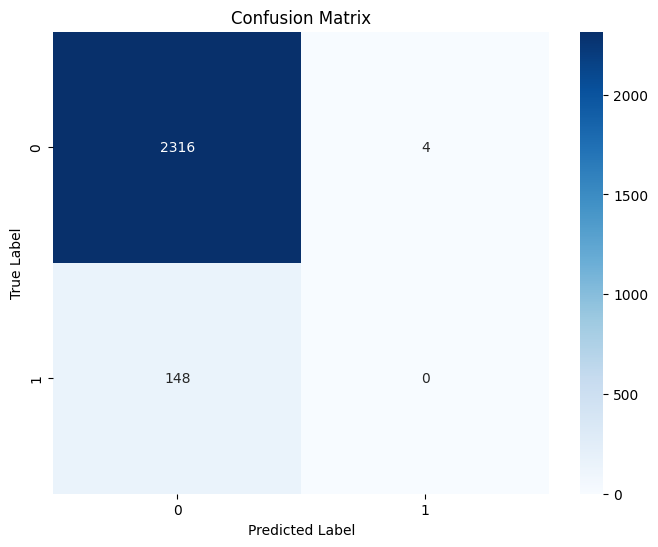

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()